In [1]:
from atmospheric_explorer.cams_interfaces import InversionOptimisedGreenhouseGas
from atmospheric_explorer.shapefile import ShapefilesDownloader
from atmospheric_explorer.utils import get_local_folder
from atmospheric_explorer.units_conversion import convert_units_array
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import xarray as xr
from datetime import datetime
import geopandas as gpd
from shapely.geometry import mapping
import rioxarray
import plotly.graph_objects as go
import shutil
import numpy as np
import statsmodels.stats.api as sms
import pandas as pd

INFO|units_conversion: Loaded constants from file constants.cfg
INFO|units_conversion: Evaluating arithmetic formulas in config
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 6.0221415e23*1e-18/(1e4*28.01e-3)
DEBUG|units_conversion: Parsing 1
DEBUG|units_conversion: Parsing 2004008
DEBUG|units_conver

In [2]:
# Remove previous data
shutil.rmtree(os.path.join(get_local_folder(), 'data'))

In [3]:
# Remove previous data
shutil.rmtree(os.path.join(get_local_folder(), 'shapefiles'))

In [4]:
#function to move from 0+360 to -180+180 long
def ds_swaplon(ds):
    return ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

In [5]:
manager = InversionOptimisedGreenhouseGas(
    data_variables='carbon_dioxide',
    file_format='zip',
    quantity='surface_flux',
    input_observations='surface',
    time_aggregation='monthly_mean',
    year=[
        '1985', '1986', '1987',
        '1988', '1989', '1990',
        '1991', '1992', '1993',
        '1994', '1995', '1996',
        '1997', '1998', '1999',
        '2000', '2001', '2002',
        '2003', '2004', '2005',
        '2006', '2007', '2008',
        '2009', '2010', '2011',
        '2012', '2013', '2014',
        '2015', '2016', '2017',
        '2018', '2019', '2020'
    ],
    month=[
        '01', '02', '03',
        '04', '05', '06',
        '07', '08', '09',
        '10', '11', '12'
    ]
)
manager.download()

INFO|cams_interfaces: Created folder C:\Users\User\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion
INFO|cams_interfaces: Created folder C:\Users\User\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_1
INFO|cams_interfaces: Finished downloading file C:\Users\User\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_1\data_1.zip
INFO|cams_interfaces: Extracted file C:\Users\User\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_1\data_1.zip to folder C:\Users\User\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_1
INFO|cams_interfaces: Updated file_full_path to wildcard path C:\Users\User\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_1\*.nc
INFO|cams_interfaces: Removed C:\Users\User\AppData\Local\AtmosphericExplorer\data\global_greenhouse_gas_inversion\data_1\data_1.zip


In [6]:
#sorted: ordina in ordine alfabetico  - globe: dentro è una lista (casting=viene 'converitito' in una lista)
files = sorted(glob(manager.file_full_path))

In [7]:
#cos'è un genereatore:
gen=(i for i in range(10))
#lista invece:
lista=[i for i in range(10)]

#come si scrive la lista [] o il generatore () si chiama list comprehension: permette di definire l'oggetto semplicemente con le parentesi

In [8]:
#il generatore se lo runni dura solo il tempo del print (se cambi gen con list non è cosi invece) - se lo runni di nuovo non contiene valori
for v in gen:
    print(v)

0
1
2
3
4
5
6
7
8
9


In [9]:
gen

<generator object <genexpr> at 0x00000263E98F98A0>

In [10]:
# Create dataframe with first file
mm = datetime.strptime(files[0].split('_')[-1].split('.')[0], '%Y%m')
df = xr.open_dataset(files[0])[['flux_foss']]
df = df.expand_dims({'time': [mm]})
# Merge remaining files
for file in files[1:]:
    mm = datetime.strptime(file.split('_')[-1].split('.')[0], '%Y%m')
    temp = xr.open_dataset(file)[['flux_foss']]
    temp = temp.expand_dims({'time': [mm]})
    df = xr.combine_by_coords([df, temp])

In [11]:
df = df.rio.write_crs('EPSG:4326')

In [12]:
sh_down = ShapefilesDownloader(
    resolution='10m',
    instance='countries_ita'
)
sh_down.download_shapefile()

DEBUG|shapefile: Created ShapefilesDownloader object with attributes
dst_dir: C:\Users\User\AppData\Local\AtmosphericExplorer\shapefiles
resolution: 10m
info_type: admin
depth: 0
instance: countries_ita

INFO|shapefile: Created folder C:\Users\User\AppData\Local\AtmosphericExplorer\shapefiles to save shapefiles
INFO|shapefile: Downloading shapefiles from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries_ita.zip
INFO|shapefile: Shapefiles downloaded to file C:\Users\User\AppData\Local\AtmosphericExplorer\shapefiles\ne_10m_admin_0_countries_ita.zip
INFO|shapefile: Shapefile extracted to C:\Users\User\AppData\Local\AtmosphericExplorer\shapefiles\ne_10m_admin_0_countries_ita
INFO|shapefile: Removed file C:\Users\User\AppData\Local\AtmosphericExplorer\shapefiles\ne_10m_admin_0_countries_ita.zip


In [13]:
sh = gpd.read_file(sh_down.shapefile_full_path, crs='EPSG:4326')

In [14]:
#all_touched=True questo parametro include tutti i pixel toccati dal poligono definito, se False include solo i pixel il cui centro è incluso nel poligono
#approvato all_touched=True
df_clipped = df.rio.clip(sh[sh['ADMIN'] == 'Italy'].geometry.apply(mapping), sh.crs, drop=True, all_touched=True)[['flux_foss']]

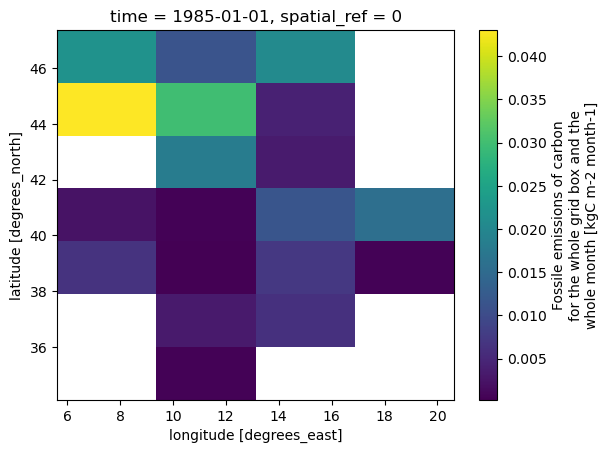

In [15]:
df_clipped['flux_foss'][0].plot()

In [16]:
# Drop all values that are null over all coords, compute the mean of the remining values over long and lat
df_clipped = df_clipped.where(~df_clipped['flux_foss'].isnull(), drop=True).sortby('time').mean(dim=['longitude', 'latitude'])

In [23]:
da_converted=convert_units_array(df_clipped['flux_foss'], "carbon_dioxide")

<Axes: xlabel='year'>

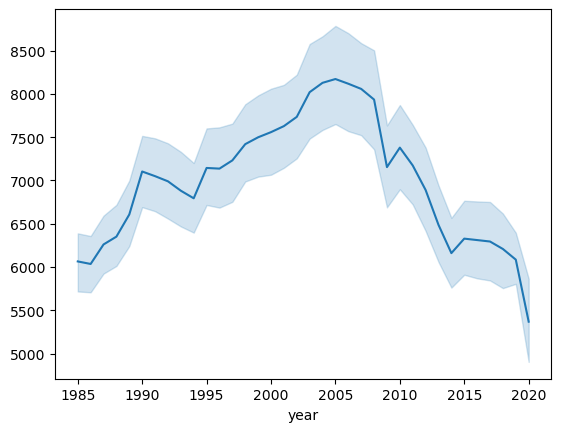

In [24]:
# Cool but not interactive
sns.lineplot(
    y=da_converted.values,
    x=da_converted.coords['time.year']
)

In [29]:
pd.DataFrame(da_converted.to_pandas(), columns=["flux_foss"])

,flux_foss
time,
1985-01-01,7160.248899
1985-02-01,6226.864074
1985-03-01,6526.292828
1985-04-01,5981.680660
1985-05-01,5714.589633
...,...
2020-08-01,5293.708418
2020-09-01,5331.323236
2020-10-01,5373.784094


In [35]:
# Xarray doesn't cover all pandas functionalities, we need to convert it to a pandas dataframe
unit=da_converted.attrs["units"]
df_pandas = pd.DataFrame(da_converted.to_pandas(), columns=["flux_foss"]).reset_index()
df_pandas['year'] = df_pandas['time'].dt.year
df_pandas = df_pandas.groupby('year').agg(mean=('flux_foss', 'mean'), ci=('flux_foss', lambda d: sms.DescrStatsW(d).tconfint_mean()))
df_pandas[['lower', 'upper']] = pd.DataFrame(df_pandas['ci'].to_list(), index=df_pandas.index)

In [40]:
# Plotly plot, it's interactive, some tweaking needed for the theme
times = df_pandas.index.tolist()
times_rev = times[::-1]

# Line 1
y1 = df_pandas['mean'].to_list()
y1_upper = df_pandas['upper'].to_list()
y1_lower = df_pandas['lower'].to_list()
y1_lower = y1_lower[::-1]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times+times_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,200,0.2)',
    line_color='rgba(0,100,200,0.2)',
    showlegend= False
))
fig.add_trace(go.Scatter(
    x=times,
    y=y1,
    line_color='rgb(0,100,200)',
    name="fossile flux"
))
fig.update_traces(mode='lines')
fig.update_xaxes(title='years')
fig.update_yaxes(title=unit)
fig.update_layout(title= {"text":"Fossile fluxes in Italy", "x":0.45, "y": 0.85, "automargin":True, "yref":"container", "font":{"size":19}})
fig.show()

In [20]:
# TODO:
## 1 - Shiftare lat e long se necessario -> EAC4 va da 0 a 360, ma Inversion è già tra -180+180
## 2 - Clip paese -> Capire se funziona, sembra funzionare
## 3 - Media annuale -> In realtà ci dovrebbe essere un modo per calcolare il CI su plotly, basta avere diversi valori per anno
##                    -> No, quella è seaborn, su plotly va fatto a mano usando ad esempio statsmodels
## 4 - Plot con CI al 95% e aggiugere la seconda linea